In [1]:
import operator
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn import feature_selection
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.pipeline import FeatureUnion
from sklearn.preprocessing import StandardScaler, RobustScaler, Imputer, LabelEncoder
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split, StratifiedKFold
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

from IPython.core.pylabtools import figsize 
%matplotlib inline

In [2]:
class ItemSelector(BaseEstimator, TransformerMixin):
    """For data grouped by feature, select subset of data at a provided key.

    The data is expected to be stored in a 2D data structure, where the first
    index is over features and the second is over samples.  i.e.

    >> len(data[key]) == n_samples

    Please note that this is the opposite convention to scikit-learn feature
    matrixes (where the first index corresponds to sample).

    ItemSelector only requires that the collection implement getitem
    (data[key]).  Examples include: a dict of lists, 2D numpy array, Pandas
    DataFrame, numpy record array, etc.

    >> data = {'a': [1, 5, 2, 5, 2, 8],
               'b': [9, 4, 1, 4, 1, 3]}
    >> ds = ItemSelector(key='a')
    >> data['a'] == ds.transform(data)

    ItemSelector is not designed to handle data grouped by sample.  (e.g. a
    list of dicts).  If your data is structured this way, consider a
    transformer along the lines of `sklearn.feature_extraction.DictVectorizer`.

    Parameters
    ----------
    key : hashable, required
        The key corresponding to the desired value in a mappable.
    """
    def __init__(self, key):
        self.key = key

    def fit(self, x, y=None):
        return self

    def transform(self, data_dict):
        return data_dict[self.key]

In [3]:
RANDOM_STATE = 42

In [36]:
genomic_dataset = pd.read_csv("../data/processed/genomic/dataset.csv.gz", index_col="MUTANT")
genomic_dataset = genomic_dataset[genomic_dataset.TYPE != "Unclassified"]

In [37]:
genomic_dataset.columns

Index(['TYPE', 'PHYLOP46WAY', 'PHASTCONS46WAY', 'INTRON', 'MISSENSE',
       'NEAR-GENE', 'NCRNA', 'CODING-SYNON', 'UNTRANSLATED', 'NONSENSE',
       'SPLICE', 'FRAMESHIFT', 'CDS-INDEL', 'STOP-LOSS'],
      dtype='object')

In [38]:
genomic_dataset.describe()

,PHYLOP46WAY,PHASTCONS46WAY,INTRON,MISSENSE,NEAR-GENE,NCRNA,CODING-SYNON,UNTRANSLATED,NONSENSE,SPLICE,FRAMESHIFT,CDS-INDEL,STOP-LOSS
count,54389.000000,54389.000000,54849.000000,54849.000000,54849.000000,54849.000000,54849.000000,54849.000000,54849.000000,54849.000000,54849.000000,54849.000000,54849.000000
mean,2.159356,0.671400,0.136101,0.990684,0.060730,0.174114,0.020092,0.053547,0.005397,0.000510,0.000055,0.000055,0.000055
std,2.291084,0.438167,0.342899,0.096072,0.238837,0.379211,0.140315,0.225124,0.073264,0.022589,0.007396,0.007396,0.007396
min,-8.217000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.287000,0.056000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.816000,0.995000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,4.235000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,6.424000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [39]:
genomic_dataset.TYPE.value_counts()

Polymorphism    39653
Disease         28855
Name: TYPE, dtype: int64

In [40]:
le = LabelEncoder()
X = genomic_dataset[~genomic_dataset.TYPE.isnull()].drop(['TYPE'], 1)
y = le.fit_transform(genomic_dataset[~genomic_dataset.TYPE.isnull()].TYPE)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, stratify=y)

In [41]:
len(cat_vars) + len(cont_vars)

37

In [42]:
cat_vars = ['INTRON',
       'MISSENSE', 'NEAR-GENE', 'NCRNA', 'CODING-SYNON', 'UNTRANSLATED',
       'NONSENSE', 'SPLICE', 'FRAMESHIFT', 'CDS-INDEL', 'STOP-LOSS']
cont_vars = genomic_dataset.columns.drop(cat_vars + ["TYPE"], 1).tolist()

impute = ('union', 
          FeatureUnion(
              transformer_list=[
                  ('continuous', Pipeline([
                      ('selector', ItemSelector(key=cont_vars)),
                      ('imputer', Imputer(missing_values="NaN", strategy="median"))
                  ])),
                  ('categorical', Pipeline([
                      ('selector', ItemSelector(key=cat_vars)),
                      ('imputer', Imputer(missing_values="NaN", strategy="most_frequent"))
                      
                  ]))
              ]))
                  

# impute = ('imputer', Imputer(missing_values="NaN", strategy="median"))

scale = ('scaler', RobustScaler())

model_dict = {
    'lr':{'pipe':[impute, scale, ('lr', LogisticRegression())],
        'params':[{'lr__C' : [.001, .01, .1, 1, 10, 100, 1000], 'lr__class_weight':[None, 'balanced']}],
        'name':'LogisticRegression'
    },
    'rf':{'pipe':[impute, ('rf', RandomForestClassifier(random_state=RANDOM_STATE))],
        'params':[{'rf__max_depth':[3,5,7], 'rf__n_estimators':[10,50,100], 'rf__max_features':[4,'sqrt',0.2]}],
        'name':'Random Forest'
    },
    'svc':{'pipe': [impute, scale, ('svc', SVC(kernel='rbf'))],
           'params':[{'svc__kernel': ['rbf'], 'svc__gamma': [1e-2, 1e-3, 1e-4, 1e-5],
                'svc__C': [0.001, 0.10, 0.1, 10, 25, 50, 100, 1000]}]
        
    },
}

In [43]:
y_train

array([1, 0, 1, ..., 0, 1, 1])

In [44]:
folds = 3
skf = StratifiedKFold(n_splits=folds, shuffle=True, random_state=1001)
algorithm = 'rf'
model = Pipeline(model_dict[algorithm]['pipe'])
param_list = [model_dict[algorithm]['params']][0]
gs = GridSearchCV(model, param_list, cv=skf.split(X_train, y_train), n_jobs=2, 
                  scoring='roc_auc', verbose=1, refit=True)

In [45]:
gs.fit(X_train, y_train)

Fitting 3 folds for each of 27 candidates, totalling 81 fits


[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   21.1s
[Parallel(n_jobs=2)]: Done  81 out of  81 | elapsed:   38.0s finished


GridSearchCV(cv=<generator object _BaseKFold.split at 0x7f8c99c803b8>,
       error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('union', FeatureUnion(n_jobs=1,
       transformer_list=[('continuous', Pipeline(memory=None,
     steps=[('selector', ItemSelector(key=['PHYLOP46WAY', 'PHASTCONS46WAY'])), ('imputer', Imputer(axis=0, copy=True, missing_values='NaN', strategy='median', verbose=0))])), ('categorical', Pipelin...stimators=10, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False))]),
       fit_params=None, iid=True, n_jobs=2,
       param_grid=[{'rf__max_depth': [3, 5, 7], 'rf__n_estimators': [10, 50, 100], 'rf__max_features': [4, 'sqrt', 0.2]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=1)

In [51]:
rf = gs.best_estimator_

In [52]:
gs.best_score_

0.8569234769765762

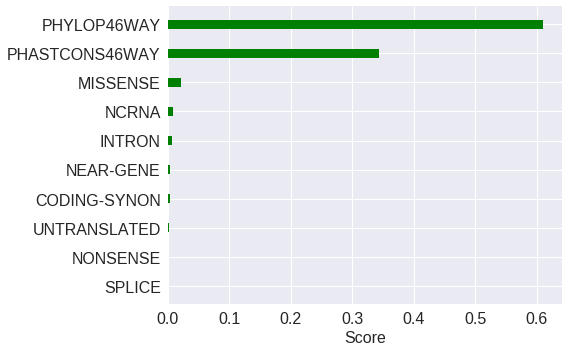

In [57]:
importances = [(X_train.columns[e], x) for e, x in enumerate(rf.steps[1][1].feature_importances_)]
importances.sort(key=operator.itemgetter(1), reverse=True)
importances = importances[:10][::-1]
figsize(8, 5)
plt.barh(np.arange(len(importances)), [y for x, y in importances], 0.3, color="g", align="center")
plt.yticks(range(len(importances)), [x for x, y in importances], rotation='horizontal', fontsize=16)
plt.xlabel("Score",fontsize=16)
plt.xticks(fontsize=16)
plt.tight_layout()

plt.savefig("/home/marlan/Desktop/importances_genomic.pdf", bbox_inches='tight', pad_inches=0.1)


In [49]:
fpr, tpr, _ = roc_curve(y_test, rf.predict_proba(X_test)[:, 1])
roc_auc = auc(fpr, tpr)

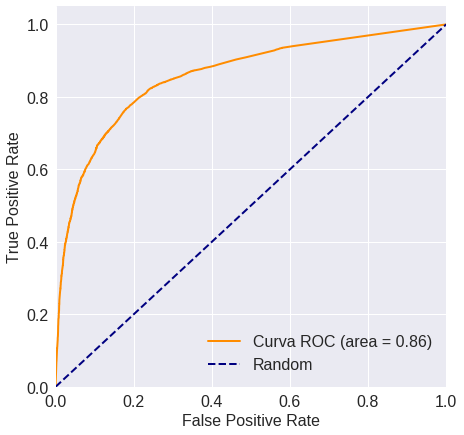

In [56]:
figsize(7,7)

lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='Curva ROC (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--', label='Random')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
# plt.title('AUC Curve')
plt.legend(loc="lower right", prop={'size': 16})

plt.savefig("/home/marlan/Desktop/auc_genomic.pdf", bbox_inches='tight', pad_inches=0.1)